function ClickConnect(){
	console.log("Working");
	document.querySelector("colab-toolbar-button").click()
} setInterval(ClickConnect, 1800000)

# LSTM으로 스팸 메일 분류하기

- dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [ ]:
from nltk.tokenize import TreebankWordTokenizer

class Vocabulary:

    def __init__(self, dataset, min_freq):
        self.itos = {0: '<PAD>', 1: '<UNK>'}
        self.stoi = {k:j for j,k in self.itos.items()}
        self.dataset = dataset
        self.min_freq = min_freq
        self.build_vocabulary()

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        tokenizer = TreebankWordTokenizer()
        return tokenizer.tokenize(text.strip().lower())

    def build_vocabulary(self):
        from collections import defaultdict
        voca_dict = defaultdict(int)
        voca_list = []
        for data in self.dataset:
            for word in self.tokenize(data):
                voca_dict[word] += 1

        for k, v in voca_dict.items():
            if v >= self.min_freq:
                voca_list.append(k)

        for i, voca in enumerate(voca_list):
            self.itos[i+2] = voca
            self.stoi[voca] = i+2

    def word2num(self, tokenized_text):
        word2num_text = []
        for token in tokenized_text:
            if token in self.stoi:
                word2num_text.append(self.stoi[token])
            else:
                word2num_text.append(self.stoi['<UNK>'])

        return word2num_text

## Load and split dataset

In [ ]:
import pandas as pd

# ===== Load dataset =====
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.loc[:, ['v1', 'v2']]
df.dropna(inplace=True)
df['v1'] = df['v1'].replace(['ham','spam'],[0,1])
df.drop_duplicates(inplace=True)

X = df['v2'].to_list()
Y = df['v1'].to_list()

In [ ]:
# ===== bulid vocabulary =====
vocab = Vocabulary(X, min_freq=3)

In [ ]:
seq_lens = []
for x in X:
    seq_lens.append(len(x))

max_len = sum(seq_lens)//len(X)
print(max_len)

78


In [ ]:
# ===== Split dataset =====
# train : test = 0.7: 0.3
train_idx = int(len(X)*0.7)
train_x, train_y = X[:train_idx], Y[:train_idx]
test_x, test_y = X[train_idx:], Y[train_idx:]

print(f"train - total: {len(train_x)}개, ham: {train_y.count(0)}개, spam: {train_y.count(1)}개")
print(f"test - total: {len(test_x)}개, ham: {test_y.count(0)}개, spam: {test_y.count(1)}개")

train - total: 3618개, ham: 3154개, spam: 464개
test - total: 1551개, ham: 1362개, spam: 189개


## Custom Dataset

In [ ]:
import torch
import torch.utils.data as data

class SmsDataset(data.Dataset):
    def __init__(self, text, label, vocab, max_len):
        super(SmsDataset, self).__init__()

        self.text = text
        self.label = label
        self.vocab = vocab
        self.max_len = max_len

    def __getitem__(self, idx):
        tmp_text = self.vocab.tokenize(self.text[idx])
        if len(tmp_text) > self.max_len:
            tmp_text = tmp_text[:self.max_len]
        else:
            tmp_text = tmp_text + ["<PAD>"]*(self.max_len - len(tmp_text))

        return {'text': torch.Tensor(self.vocab.word2num(tmp_text)).to(torch.int32), 'label': self.label[idx]}

    def __len__(self):
        return len(self.text)

In [ ]:
train_set = SmsDataset(train_x, train_y, vocab, max_len=max_len)
test_set = SmsDataset(test_x, test_y, vocab, max_len=max_len)

## Model Define - LSTM Cell 구현하여 사용

In [ ]:
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W_ih = nn.Linear(self.input_size, 4 * self.hidden_size, bias=True)
        self.W_hh = nn.Linear(self.hidden_size, 4 * self.hidden_size, bias=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h, c):
        gates = self.W_ih(x) + self.W_hh(h)
        f, i, g, o = gates.chunk(4, dim=1)
        f_t = self.sigmoid(f)
        i_t = self.sigmoid(i)
        g_t = self.tanh(g)
        o_t = self.sigmoid(o)

        c = torch.mul(f_t, c) + torch.mul(i_t,g_t)
        h = torch.mul(o_t, self.tanh(c))

        return h, c

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.emb = nn.Embedding(vocab_size, input_size, padding_idx=0)
        self.lstm = LSTMCell(input_size, hidden_size, output_size)

        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h = torch.zeros(1, self.hidden_size)
        c = torch.zeros(1, self.hidden_size)
        for x_t in x:
            x_t = self.emb(x_t).unsqueeze(0)
            h, c = self.lstm(x_t, h, c)
        output = self.softmax(self.fc(h))

        return output

### Train

In [ ]:
import torch.optim as optim

epochs = 100
learning_rate = 0.001
embedding_size = 32
hidden_size = 32
num_class = 2

model = LSTM(embedding_size, hidden_size, num_class, len(vocab))
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

all_losses = []

model.train()
for epoch in range(1, epochs+1):
    cur_loss = 0
    for i in range(len(train_set)):
        model.zero_grad()
        optimizer.zero_grad()
        output = model(train_set[i]['text'])
        y_true = torch.tensor([train_set[i]['label']], dtype=torch.long)
        loss = loss_fn(output, y_true)
        loss.backward()
        optimizer.step()
        cur_loss += loss.item()

    all_losses.append(cur_loss/len(train_set))
    if epoch%5==0:
        print(f"epoch {epoch} - loss: {all_losses[-1]}")

epoch 5 - loss: 0.38513035222351544
epoch 10 - loss: 0.3840665265005182
epoch 15 - loss: 0.3804619511859821
epoch 20 - loss: 0.17464792391180017
epoch 25 - loss: 0.07543551793443337
epoch 30 - loss: 0.04860743667310585
epoch 35 - loss: 0.02920826381189565
epoch 40 - loss: 0.025688636954725567
epoch 45 - loss: 0.01616173394370651
epoch 50 - loss: 0.0184217771244714
epoch 55 - loss: 0.015505994758065585
epoch 60 - loss: 0.015442463740043301
epoch 65 - loss: 0.013849925157067431
epoch 70 - loss: 0.014154265413824505
epoch 75 - loss: 0.012752701759816782
epoch 80 - loss: 0.014523930922775144
epoch 85 - loss: 0.013399680922662265
epoch 90 - loss: 0.009931715219217525
epoch 95 - loss: 0.009026051593998798
epoch 100 - loss: 0.00840519785660685


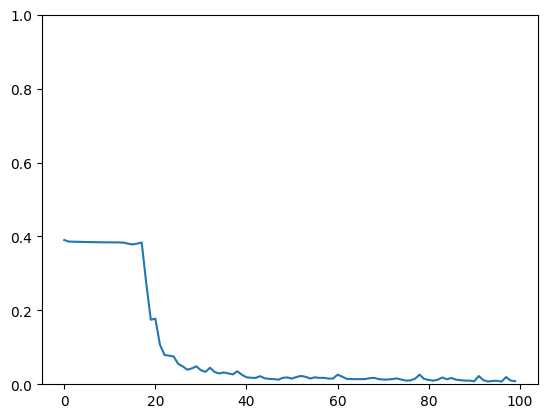

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylim([0, 1.0])
plt.plot(all_losses)

### Evaluate

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for i in range(len(test_set)):
        data = test_set[i]
        text = data['text']
        y_true.append(train_set[i]['label'])
        output = model(text)
        _, y = torch.max(output, 1)
        y_pred.append(y[0])

f1 = f1_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f1, acc)

0.14177215189873418 0.781431334622824


## Model Define - nn.LSTM 사용

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, batch_size, embedding_size, hidden_size, output_size, vocab_size, n_layers):
        super(LSTM, self).__init__()

        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.emb = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.emb(x)
        output, (h_n, c_n) = self.lstm(x)
        output = self.softmax(self.fc(output[:, -1, :]))

        return output

### Train

In [ ]:
def train(model, loss_fn, optimizer, train_loader):
    model.train()

    cur_loss = 0

    for i, data in enumerate(train_loader):
        model.zero_grad()
        optimizer.zero_grad()

        texts = data['text']
        y_true = data['label']

        outputs = model(texts)

        loss = loss_fn(outputs, y_true)
        loss.backward()
        optimizer.step()
        cur_loss += loss.item()

    return outputs, cur_loss/(len(train_loader))

In [ ]:
epochs = 100
learning_rate = 0.001
batch_size = 64
embedding_size = 32
hidden_size = 32
num_class = 2
n_layers = 2

train_loader = data.DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size, shuffle=True, drop_last=True)

In [ ]:
import torch.optim as optim

model = LSTM(batch_size, embedding_size, hidden_size, num_class, len(vocab), n_layers)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

all_losses = []

for i in range(1, epochs+1):
    output, loss = train(model, loss_fn, optimizer, train_loader)
    all_losses.append(loss)

    if i%5==0:
        print(f"epoch {i} - loss: {loss}")

epoch 5 - loss: 0.38376520574092865
epoch 10 - loss: 0.38236559288842337
epoch 15 - loss: 0.38412944466939997
epoch 20 - loss: 0.22059660857277258
epoch 25 - loss: 0.07318351143372379
epoch 30 - loss: 0.09283136852484729
epoch 35 - loss: 0.05853673637778099
epoch 40 - loss: 0.05016514888432409
epoch 45 - loss: 0.04619420037072684
epoch 50 - loss: 0.06285623935816277
epoch 55 - loss: 0.03879941250696512
epoch 60 - loss: 0.032567245686160665
epoch 65 - loss: 0.09197147624633674
epoch 70 - loss: 0.03662163977112089
epoch 75 - loss: 0.03550108120543882
epoch 80 - loss: 0.03532559848307366
epoch 85 - loss: 0.0355093243166006
epoch 90 - loss: 0.03532667945338679
epoch 95 - loss: 0.03365725977346301
epoch 100 - loss: 0.03535643510154581


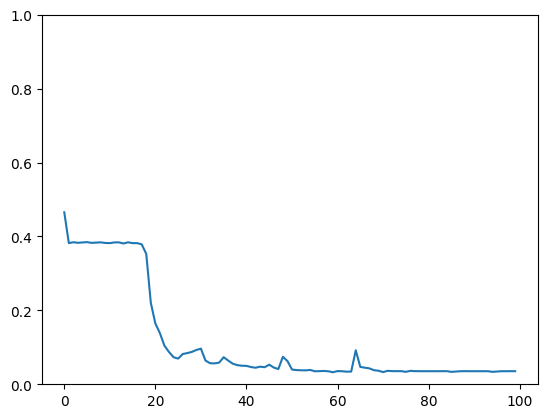

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylim([0, 1.0])
plt.plot(all_losses)

### Evaluate

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate(model, test_loader):
    model.eval()
    f1, acc = 0, 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            texts = data['text']
            y_true = data['label']
            output = model(texts)

            _, y_pred = torch.max(output, 1)

            f1 += f1_score(y_true, y_pred)
            acc += accuracy_score(y_true, y_pred)

    return f1/len(test_loader), acc/len(test_loader)

In [ ]:
f1, acc = evaluate(model, test_loader)
print(f1, acc)

0.8465880118483095 0.9641927083333334
